In [1]:
import centralized as CP
import davisyin as DY
import admm as admm
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib.pyplot as plt
import proyecciones as pro
import time
import briceno as BA

In [2]:
# Seteamos los parámetros:
N, M = 3, 5  # Son 2 tecnologías, 10 escenarios.

# Probabilidades:

Sigma = np.ones((1,M))
Sigma /= Sigma.sum()
    
# Parámetros funciones:
I    = 50 * np.ones((N, 1))
MC   = np.array([np.diag(1000*np.ones(N)) for m in range(M)])
VOLL = 10000.0
D    = 1000.0*np.ones((1,M))

e1  = VOLL*1.1
e2  = VOLL*1.1
e31 = VOLL*1.1
e32 = VOLL*1.1

Q1, B1 = np.zeros((N,N)), I
Q2, B2 = 0.01*MC, np.zeros((N,M))
Q3, B3 = np.zeros((1,M)), VOLL*np.ones((1,M))
    

frobenius_norm_of_MC = (e1+e2)*N*0.5+e31+e32+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()

def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, e1 = e1, N = N):
    return np.dot(Q_1,x1)+B_1 - e1*np.dot(np.identity(N),np.maximum(-x1,0))

    # me queda e2 * max{0,-x2}
def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), e2 = e2, N = N, M = M):
    
    return np.einsum('ijk,ki->ji', Q_2, x2)+B_2 - e2*np.einsum('ijk,ki->ji', np.array([np.diag(np.ones(N)) for m in range(M)]), np.maximum(-x2,0))

    # me queda e31 * max{0,-x3} &  e32 * max{0,-D+x3}
def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), D=D, e31=e31, e32= e32, M = M):
    return Q_3*x3+B_3 - e31*np.dot(np.maximum(-x3,0),np.identity(M)) - e32*np.dot(np.maximum(-D+x3,0),np.identity(M))

    
def Grad_Phi(x1,x2,x3, P = Sigma):
        return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)
    
def Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, C_1 = 0.0, e1 = e1):
    return 0.5*np.einsum('ij,ji -> i', x1.T,np.dot(Q_1,x1))[:,np.newaxis]+np.dot(x1.T, B_1)+C_1 + e1/2*LA.norm(np.maximum(-x1.flatten(),0))**2

def Phi_2_xi(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), C_2 = np.zeros((M, 1))):
    return 0.5*np.einsum('ij,ji -> i', x2.T, np.einsum('ijk,ki -> ji', Q_2, x2))[:,np.newaxis]+np.einsum('ij,ji->i',x2.T,B_2)[:,np.newaxis]+C_2 + e2/2*LA.norm(np.maximum(-x2.flatten(),0))**2
    
def Phi_3_xi(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), C_3 = -VOLL*D ):
        return (0.5*x3*Q_3*x3+B_3*x3+C_3).T + e31/2*LA.norm(np.maximum(-x3.flatten(),0))**2 + e32/2*LA.norm(np.maximum((D-x3).flatten(),0))**2


def objective_function(x1, x2, x3, P = Sigma, NA = True):
    # 
    # NA = True, cumple la funcion que si se impuso 
    #      la condición de no anticipatividad para x1
    #      entonces, Phi_1(x1).shape == (M,1)
    if NA:
        return np.dot(P, Phi_1(x1) +Phi_2_xi(x2)+Phi_3_xi(x3))
    else:
        return Phi_1(x1)+ np.dot(P, Phi_2_xi(x2)+Phi_3_xi(x3))


In [43]:
Times = {}
Number_iterations = 30000


cp = time.time()
x1, x2, x3, rho = map(np.array, CP.modelo())
fin = time.time()

Times["CP"] = fin - cp

x1 = x1[:,np.newaxis]
x2 = x2.T
x3 = x3[np.newaxis,:]


dy = time.time()
DY_list   = DY.Davis_Yin(N, M, frobenius_norm_of_MC, Grad_Phi, Number_iterations, D)
fin = time.time()

Times["DY"] = fin - dy

adm = time.time()
ADMM_list = admm.ADMM(Number_iterations, N, M, (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D, e1, e2, e31, e32)
fin = time.time()

Times["ADMM"] = fin - adm

ba = time.time()
BA_list   = BA.Briceno_Arias(N, M, Number_iterations, frobenius_norm_of_MC, Grad_Phi, Sigma, D)
fin = time.time()

Times["BA"] = fin - ba
Times

{'CP': 0.08441805839538574,
 'DY': 9.069823026657104,
 'ADMM': 6.442718744277954,
 'BA': 13.369980335235596}

In [44]:
x1, x2, x3

(array([[333.33333],
        [333.33333],
        [333.33333]]),
 array([[333.33333, 333.33333, 333.33333, 333.33333, 333.33333],
        [333.33333, 333.33333, 333.33333, 333.33333, 333.33333],
        [333.33333, 333.33333, 333.33333, 333.33333, 333.33333]]),
 array([[0., 0., 0., 0., 0.]]))

In [45]:
def generate_list(lista, algoritmo, solution, objective_function, Demanda):
    
    # unpack solution
    x1, x2, x3 = solution

    # create a list with index of graphics
    iterations = list(range(len(lista)))
    
    # create list to return
    x_solution   = []
    Fx_solution  = []
    Non_anti_sol = []
    equili_solut = []
    
    
    # create arrays for each graph
        
    if algoritmo == "DY":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, x3_algo = x_algo
            
            x_solution.append( LA.norm(x1_algo - x1) + LA.norm(x2_algo - x2) + LA.norm(x3_algo - x3) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( LA.norm(x1_algo - np.roll(x1_algo, 1, axis=1)) ) #No aplica a DY
            equili_solut.append( LA.norm( x2_algo.sum(axis=0) - (D - x3_algo) ) )
            
    elif algoritmo == "ADMM":
        for elemento in lista:
            x1_algo, x2_algo, x3_algo = elemento[0]
            x_solution.append( LA.norm(x1_algo - x1) + LA.norm(x2_algo - x2) + LA.norm(x3_algo - x3) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( LA.norm(x1_algo - np.roll(x1_algo, 1, axis=1)) ) #No aplica a DY
            equili_solut.append( LA.norm( x2_algo.sum(axis=0) - (D - x3_algo) ) )

    elif algoritmo == "BA":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, _, x3_algo = x_algo
            # x2_algo y _ tienen el mimso valor por componente
            
            x_solution.append( LA.norm(x1_algo - x1) + LA.norm(x2_algo - x2) + LA.norm(x3_algo - x3) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( LA.norm(x1_algo - np.roll(x1_algo, 1, axis=1)) ) #No aplica a DY
            equili_solut.append( LA.norm( x2_algo.sum(axis=0) - (D - x3_algo) ) )
            
    
    
    k = 0
    return iterations[k:], x_solution[k:], Fx_solution[k:], Non_anti_sol[k:], equili_solut[k:]

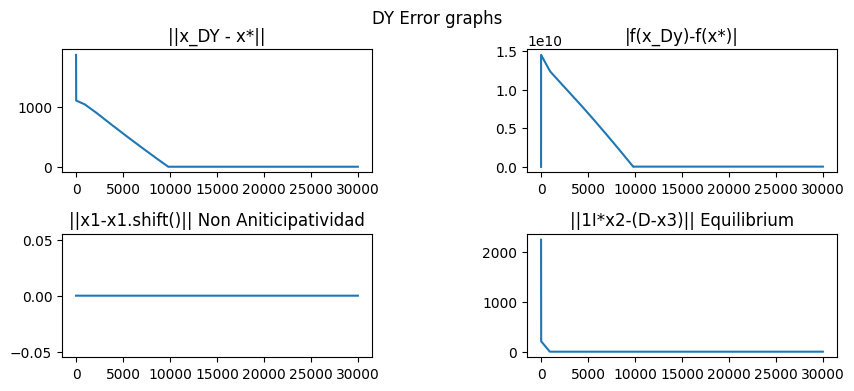

In [46]:
iter_DY, x_DY_sol, Fx_DY_sol, Non_anti_DY, equili_DY_solu = generate_list(DY_list, "DY", (x1, x2, x3), objective_function, D)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))  # Ajusta el tamaño de la figura
fig.suptitle('DY Error graphs')

# Ajuste del espacio entre gráficos
plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax1.plot(iter_DY, x_DY_sol,       '-', linewidth=1.5)  
ax1.set_title('||x_DY - x*||')

ax2.plot(iter_DY, Fx_DY_sol,      '-', linewidth=1.5)  
ax2.set_title('|f(x_Dy)-f(x*)|')

ax3.plot(iter_DY, Non_anti_DY,    '-', linewidth=1.5)  
ax3.set_title('||x1-x1.shift()|| Non Aniticipatividad')

ax4.plot(iter_DY, equili_DY_solu, '-', linewidth=1.5)  
ax4.set_title('||1I*x2-(D-x3)|| Equilibrium')

plt.show()

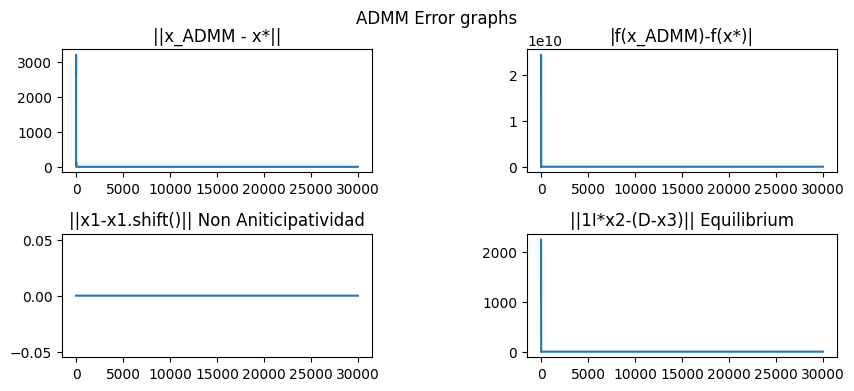

In [47]:
iter_ADMM, x_ADMM_sol, Fx_ADMM_sol, Non_anti_ADMM, equili_ADMM_solu = generate_list(ADMM_list, "ADMM", (x1, x2, x3), objective_function, D)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))  # Ajusta el tamaño de la figura
fig.suptitle('ADMM Error graphs')

# Ajuste del espacio entre gráficos
plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax1.plot(iter_ADMM, x_ADMM_sol,       '-', linewidth=1.5)  
ax1.set_title('||x_ADMM - x*||')

ax2.plot(iter_ADMM, Fx_ADMM_sol,      '-', linewidth=1.5)  
ax2.set_title('|f(x_ADMM)-f(x*)|')

ax3.plot(iter_ADMM, Non_anti_ADMM,    '-', linewidth=1.5)  
ax3.set_title('||x1-x1.shift()|| Non Aniticipatividad')

ax4.plot(iter_ADMM, equili_ADMM_solu, '-', linewidth=1.5)  
ax4.set_title('||1I*x2-(D-x3)|| Equilibrium')

plt.show()

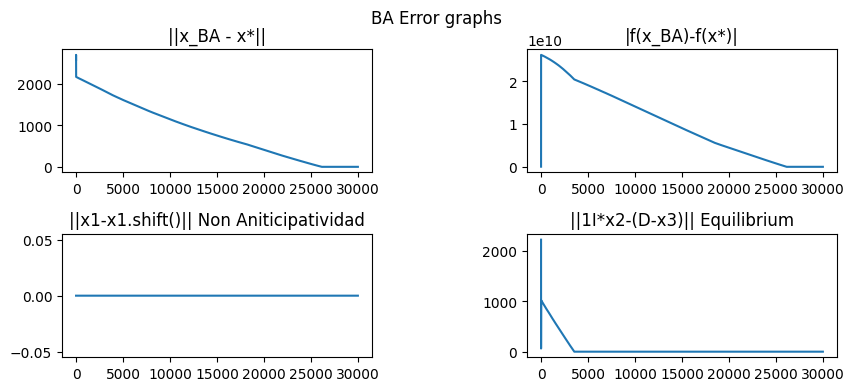

In [48]:
iter_BA, x_BA_sol, Fx_BA_sol, Non_anti_BA, equili_BA_solu = generate_list(BA_list, "BA", (x1, x2, x3), objective_function, D)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))  # Ajusta el tamaño de la figura
fig.suptitle('BA Error graphs')

# Ajuste del espacio entre gráficos
plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax1.plot(iter_BA, x_BA_sol, '-', linewidth=1.5)  
ax1.set_title('||x_BA - x*||')

ax2.plot(iter_BA, Fx_BA_sol, '-', linewidth=1.5)  
ax2.set_title('|f(x_BA)-f(x*)|')

ax3.plot(iter_BA, Non_anti_BA, '-', linewidth=1.5)  
ax3.set_title('||x1-x1.shift()|| Non Aniticipatividad')

ax4.plot(iter_BA, equili_BA_solu, '-', linewidth=1.5)  
ax4.set_title('||1I*x2-(D-x3)|| Equilibrium')

plt.show()

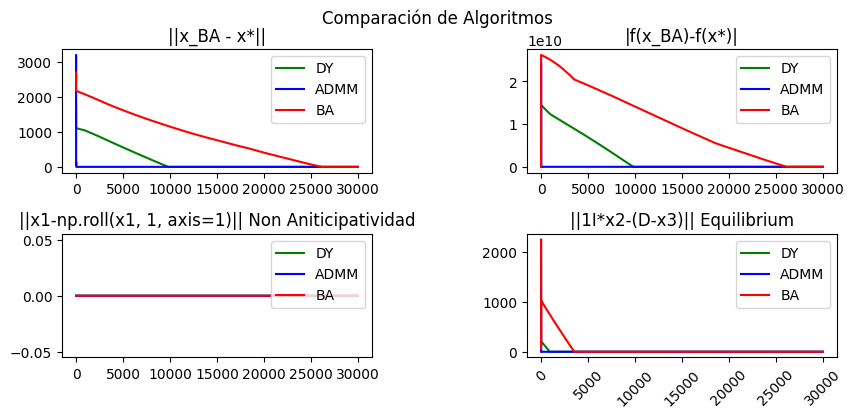

In [49]:
# Se generan los datos para cada algoritmo
#iter_DY  , x_DY_sol  , Fx_DY_sol  , Non_anti_DY  , equili_DY_solu   = generate_list(DY_list,     "DY", (x1, x2, x3), objective_function, D)
#iter_ADMM, x_ADMM_sol, Fx_ADMM_sol, Non_anti_ADMM, equili_ADMM_solu = generate_list(ADMM_list, "ADMM", (x1, x2, x3), objective_function, D)
#iter_BA  , x_BA_sol  , Fx_BA_sol  , Non_anti_BA  , equili_BA_solu   = generate_list(BA_list,     "BA", (x1, x2, x3), objective_function, D)

# Se crea la figura
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))  # Ajusta el tamaño de la figura
fig.suptitle('Comparación de Algoritmos')

# Ajuste del espacio entre gráficos
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Gráficos para el algoritmo DY
ax1.plot(iter_DY, x_DY_sol,           '-', linewidth=1.5, label='DY'  , color='green')  
ax2.plot(iter_DY, Fx_DY_sol,          '-', linewidth=1.5, label='DY'  , color='green')  
ax3.plot(iter_DY, Non_anti_DY,        '-', linewidth=1.5, label='DY'  , color='green')  
ax4.plot(iter_DY, equili_DY_solu,     '-', linewidth=1.5, label='DY'  , color='green')  

# Gráficos para el algoritmo ADMM
ax1.plot(iter_ADMM, x_ADMM_sol,       '-', linewidth=1.5, label='ADMM', color='blue')  
ax2.plot(iter_ADMM, Fx_ADMM_sol,      '-', linewidth=1.5, label='ADMM', color='blue')  
ax3.plot(iter_ADMM, Non_anti_ADMM,    '-', linewidth=1.5, label='ADMM', color='blue')  
ax4.plot(iter_ADMM, equili_ADMM_solu, '-', linewidth=1.5, label='ADMM', color='blue')  

# Gráficos para el algoritmo BA
ax1.plot(iter_BA, x_BA_sol,           '-', linewidth=1.5, label='BA'  , color='red')  
ax2.plot(iter_BA, Fx_BA_sol,          '-', linewidth=1.5, label='BA'  , color='red')  
ax3.plot(iter_BA, Non_anti_BA,        '-', linewidth=1.5, label='BA'  , color='red')  
ax4.plot(iter_BA, equili_BA_solu,     '-', linewidth=1.5, label='BA'  , color='red')  

# Titles
ax1.set_title('||x_BA - x*||')
ax2.set_title('|f(x_BA)-f(x*)|')
ax3.set_title('||x1-np.roll(x1, 1, axis=1)|| Non Aniticipatividad')
ax4.set_title('||1I*x2-(D-x3)|| Equilibrium')

# Añadir leyenda
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# Rotate x-axis
plt.xticks(rotation=45) 
# show graphs
plt.show()

In [50]:
Times

{'CP': 0.08441805839538574,
 'DY': 9.069823026657104,
 'ADMM': 6.442718744277954,
 'BA': 13.369980335235596}